---
title: "Machine Learning pour l'Assurance"
subtitle: "sujet 2 - préparation de la donnée"
date: 07/15/2024
date-format: long
author: Bruno KUBECZKA
lang: fr-FR
format:
    html:

        title-block-banner: true
            
        toc: true
        toc-depth: 4
        toc-expand: 2
        toc-location: right
        toc-title: "<b>SOMMAIRE</b>"

        number-sections: true
        number-depth: 2

---

# CONSTANTES ET LIBRAIRIES

In [1]:
# ==========
# LIBRAIRIES
# ==========

import pickle
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# ==========
# CONSTANTES
# ==========

## Environnement de développement
PYTHON_VERSION = "3.12.3"

## Base de données
DIR_DATA = "./data"
FILENAME_BASE_AUTO = "base_auto_projet.pkl"
FILENAME_PREPROCESSED = "./preprocess_data.pkl"

## Split Train / Test
TRAIN_SIZE = 0.2
# TRAIN_SIZE = 0.8 A valider dans une version finale


In [3]:
# ============================
# VERIFICATION avant EXECUTION
# ============================

# Vérification de la version python courante
if not(PYTHON_VERSION in sys.version):
    print(f"ATTENTION : ce notebook a été développé sous python {PYTHON_VERSION}.")
    print(f"version courante de python : {sys.version}")


# JEU DE DONNEES <a class="anchor" id="first-bullet"></a>

## Chargement des données

In [4]:
filename = os.path.join(DIR_DATA, FILENAME_BASE_AUTO)
print(filename)

./data\base_auto_projet.pkl


In [5]:
with open(file=os.path.join(DIR_DATA, FILENAME_BASE_AUTO), mode="rb") as f:
    base_auto = pd.read_pickle(f)

## Etat du jeu de données <a id="etat_jeu_de données"></a>

#### Dimensions

In [6]:
base_auto.shape

(72878, 21)

Taille du jeu de données

- 72878 observations

- 21 features

### Doublons - Indexation des observations

On recherche dans la base de données d'éventuels doublons parmi les combinaisons `ID` / `ANNEE_OBS` / `MOIS_OBS` (hors éventuelles données manquantes)

In [7]:
print(f"{'Nombre de données manquantes dans la colonne ID': >55} : {base_auto.ID.isna().sum()}")
print(f"{'Nombre de données manquantes dans la colonne ANNEE_OBS': >55} : {base_auto.ANNEE_OBS.isna().sum()}")
print(f"{'Nombre de données manquantes dans la colonne MOIS_OBS': >55} : {base_auto.MOIS_OBS.isna().sum()}")

        Nombre de données manquantes dans la colonne ID : 0
 Nombre de données manquantes dans la colonne ANNEE_OBS : 0
  Nombre de données manquantes dans la colonne MOIS_OBS : 0


In [8]:
doublons_id_annee_mois = base_auto.value_counts(subset=["ID", "ANNEE_OBS", "MOIS_OBS"],
                       dropna=False,
                       sort=True,
                       ascending=False)

print(f'{"Nombre d'observations dans la base": >45} : {base_auto.shape[0]}')
print(f'{"Nombre de combinaisons uniques ID/ANNEE/MOIS": >45} : {doublons_id_annee_mois.shape[0]}')
print(f'{"soit Nombre de doublons constatés": >45} : {base_auto.shape[0] - doublons_id_annee_mois.shape[0]}')


           Nombre d'observations dans la base : 72878
 Nombre de combinaisons uniques ID/ANNEE/MOIS : 68955
            soit Nombre de doublons constatés : 3923


Les observations de la base peuvent être indéxées par le trio `ID` / `ANNEE_OBS` / `MOIS_OBS`.

Néanmoins, dans ces conditions, on note un **grand nombre de doublons d'index**.

**BKU** : **hypothèses** (à clarifier / vérifier)

- Les doublons sont peut-être liés à une évolution du contrat dans sa vie (changement de formule, changement de véhicule, changement d'adresse) : à vérifier

- Les doublons sont peut-être liés à une rupture de contrat dans le temps, avec reprise ultérieure : vérifier la continuité des séquences `ANNEE_OBS` et `MOIS_OBS`

**Nombre de contrats suivis**

In [9]:
print(f"{'Nombre de contrats suivis dans la base': >45} : {base_auto.ID.unique().shape[0]}")

       Nombre de contrats suivis dans la base : 3688


#### Suivi d'un contrat

On regarde les observations du contrat XXX (dont on sait inclure un doublon, et dont on sait qu'il a au moins un sinistre) pour comprendre le fonctionnement des observations.

On cherche la liste des `ID` pour lesquels

- on dispose de plus de 12 observations

- au moins une observation dispose NB_SINISTRES égal à 2

- on observe un doublon

In [10]:
ID_NB_OBS_MIN = 20
ID_NB_SINISTRES_MIN = 2


**Liste des contrats avec plus de 12 observations**

In [11]:
ID_1 = base_auto.groupby(by="ID").ID.count()
ID_1 = (pd.Series(ID_1.values)>ID_NB_OBS_MIN)
print(f"{'Nombre de contrats avec un grand nombre d\'observations': >45} : {ID_1.sum()} ({ID_NB_OBS_MIN} observations minimum)")

Nombre de contrats avec un grand nombre d'observations : 1331 (20 observations minimum)


**Liste des contrats pour lesquels NB_SINISTRES = 2**

...

**Liste des contrats avec doublons**

...

### Données manquantes

In [12]:
print("INVENTAIRE DES DONNEES MANQUANTES :")
print("=================================")
base_auto.isna().sum()

INVENTAIRE DES DONNEES MANQUANTES :


FORMULE                      0
EXPOSITION                   0
V_TYPE_GARAGE                0
V_MARQUE                     0
V_GROUPE_SRA                 0
V_PUISSANCE               3580
V_USAGE                      0
C_CSP                        0
C_ZONE_RISQUE                0
C_TYPE_PERMIS                0
C_CRM                        0
C_ANCIENNETE_ASSURANCE       0
C_ANCIENNETE_PERMIS          0
C_AGE                     7418
V_ANCIENNETE                 0
CHARGE                       0
NB_SINISTRES                 0
ID                           0
CODE_POSTAL                911
ANNEE_OBS                    0
MOIS_OBS                     0
dtype: int64

**BKU** : imputation

- `AGE`, `CODE_POSTAL`, `V_PUISSANCE` si les ID forment un historique, vérifier si une des observation dispose d'un âge. 
Si c'est le cas, extrapoler les valeurs sur les autres observations.

- `V_PUISSANCE`

    - Vérifier l'historique pour retrouver une valeur, 
    
    - si manquante, regarder s'il est possible de rapprocher de `V_GROUPE_SRA`

- `CODE_POSTAL` : 

    - étudier l'historique des observations du contrat

    - pour les données qui restent manquantes, identifier une stratégie

**BKU**

Faire ici un PygWalker avec les données avant manipulation

- Statuer sur les 16 valeurs C_ZONE_RISQUE 2.81 : modalités ? ou données manquantes ?

- 

## Définition des variables

La base de données donne un historique des contrats d'assurance automobile.

Les observations sont collectées mensuellement sur une période qui s'étend de **Mars 2016** à **Juillet 2022**.

In [13]:
base_auto.columns.array

<NumpyExtensionArray>
[               'FORMULE',             'EXPOSITION',          'V_TYPE_GARAGE',
               'V_MARQUE',           'V_GROUPE_SRA',            'V_PUISSANCE',
                'V_USAGE',                  'C_CSP',          'C_ZONE_RISQUE',
          'C_TYPE_PERMIS',                  'C_CRM', 'C_ANCIENNETE_ASSURANCE',
    'C_ANCIENNETE_PERMIS',                  'C_AGE',           'V_ANCIENNETE',
                 'CHARGE',           'NB_SINISTRES',                     'ID',
            'CODE_POSTAL',              'ANNEE_OBS',               'MOIS_OBS']
Length: 21, dtype: object

| Variable | Type | Description |
|:--------|------|:-------------|
| **Variables d'intérêt** | - | - |
| `EXPOSITION` | numérique | L'exposition donne la durée de couverture du contrat au moment de l'observation.</br>Elle est donnée mensuellement en ratio annuel i.e. la borne supérieure pour une observation est de 1/12. |
| `CHARGE` | numérique | Coût des sinistres sur la période d'exposition observée (maximum un mois) |
| `NB_SINISTRES` | numérique | Nombre de sinistres sur la période d'exposition observée (maximum un mois) (BKU : depuis le début du contrat ?) |
| **Caractéristiques du contrat** | - | - |
| `ID` | numérique | Identifiant du contrat d'assurance automobile |
| `ANNEE_OBS` | numérique | Année de l'observation |
| `MOIS_OBS` | numérique | Mois de l'observation |
| `FORMULE` | catégorielle | Formule de l'assurance </br> TOUT_RISQUE / CONFORT / BASE |
| `CODE_POSTAL` | numérique | Lieu d'attachement du véhicule sur la période d'exposition observée |
| **Caractéristiques du véhicule** | - | - |
| `V_TYPE_GARAGE` | catégorielle | Mode de parking habituel du véhicule </br> VOIE_PUBLIQUE - BOX_FERME - PARKING_OUVERT - PARKING-FERME |
| `V_MARQUE` | catégorielle | - |
| `V_GROUPE_SRA` | numérique | - |
| `V_PUISSANCE` | numérique | Puissance fiscale du véhicule</br>valeur numérique entière ordonnées supérieure ou égale à 1 |
| `V_USAGE` | catégorielle | - |
| `V_ANCIENNETE` | numérique | - |
| **Caractéristiques du conducteur** | - | - |
| `C_CSP` | catégorielle | - |
| `C_ZONE_RISQUE` | catégorielle | Codification du risque de la zone d'habitation du conducteur sous la forme d'un entier de 1 à 5</br>Il n'est pas précisé si la valeur augmente avec le risque encouru ; on considérera que la variable n'est pas ordonnée et on la considère comme catégorielle |
| `C_TYPE_PERMIS` | catégorielle | - |
| `C_CRM` | numérique | Coefficient de réduction-majoration</br>https://www.allianz.fr/assurance-particulier/vehicules/assurance-auto/conseils-pratiques/bonus-malus.html</br>Bonus-Malus de valeurs comprises entre 0.5 et 3.5.</br>Coefficient de prime d'assurance fonction du nombre de sinistres responsables.|
| `C_ANCIENNETE_ASSURANCE` | numérique | Ancienneté du contrat d'assurance sous la forme d'année exprimée en mois (0, 12, 24)</br>La donnée est transformée en donnée entière ordonnée pour apporter de l'information aux modèles linéaires. |
| `C_ANCIENNETE_PERMIS` | numérique | - |
| `C_AGE` | numérique | - |


## Alignement des types

### Types initiaux

In [14]:
base_auto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72878 entries, 0 to 72877
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FORMULE                 72878 non-null  object 
 1   EXPOSITION              72878 non-null  float64
 2   V_TYPE_GARAGE           72878 non-null  object 
 3   V_MARQUE                72878 non-null  object 
 4   V_GROUPE_SRA            72878 non-null  float64
 5   V_PUISSANCE             69298 non-null  float64
 6   V_USAGE                 72878 non-null  object 
 7   C_CSP                   72878 non-null  object 
 8   C_ZONE_RISQUE           72878 non-null  float64
 9   C_TYPE_PERMIS           72878 non-null  object 
 10  C_CRM                   72878 non-null  float64
 11  C_ANCIENNETE_ASSURANCE  72878 non-null  object 
 12  C_ANCIENNETE_PERMIS     72878 non-null  float64
 13  C_AGE                   65460 non-null  float64
 14  V_ANCIENNETE            72878 non-null  flo

**BKU**

Corriger les types
- V_PUISSANCE en numérique entier (valeur ordonnée de 1 à +inf) => OK
- C_ZONE_RISQUE en catégorielle "entier" avec NA pour la zone mal identifiée => OK
- C_ANCIENNETE_ASSURANCE en numérique

- V_GROUPE_SRA en catégorielle ?
- CODE_POSTALE en numérique ?

### Transformations

`V_PUISSANCE` : 

- La cible sont des valeurs en entiers reflétant l'ordonnancement des valeurs

- Néanmoins V_PUISSANCE contient des NA ; pour éviter que l'imputation par KNN ne prédisse des réels et reste dans les champs des valeurs proposées, on va maintenir en catégorielle

In [15]:
base_auto.V_PUISSANCE.dtype

dtype('float64')

In [16]:
base_auto.V_PUISSANCE.value_counts()

V_PUISSANCE
1.0    66180
6.0     1833
5.0      659
0.0      430
2.0      157
4.0       34
7.0        5
Name: count, dtype: int64

In [17]:
# base_auto.V_PUISSANCE = base_auto.V_PUISSANCE.astype("Int64")

In [18]:
base_auto.V_PUISSANCE = base_auto.V_PUISSANCE.astype("object")

In [19]:
base_auto.V_PUISSANCE.dtype

dtype('O')

In [20]:
base_auto.V_PUISSANCE.value_counts()

V_PUISSANCE
1.0    66180
6.0     1833
5.0      659
0.0      430
2.0      157
4.0       34
7.0        5
Name: count, dtype: int64

`C_ZONE_RISQUE` : 

- marquer les valeurs 2.81 en valeurs manquantes

- transformer les données en entiers

- Néanmoins `C_RISQUE_ZONE` contient des `NA` ; pour éviter que l'imputation par KNN ne prédisse des réels et reste dans les champs des valeurs proposées, on va maintenir en catégorielle

In [21]:
C_ZONE_RISQUE_value_counts = base_auto.C_ZONE_RISQUE.value_counts()
C_ZONE_RISQUE_value_counts

C_ZONE_RISQUE
2.000000    36327
1.000000    26199
5.000000     7928
4.000000     2408
2.812471       16
Name: count, dtype: int64

In [22]:
index = C_ZONE_RISQUE_value_counts.sort_values(ascending=True).index[0] # index de la valeur la moins représentée
base_auto.loc[base_auto.C_ZONE_RISQUE==index, "C_ZONE_RISQUE"]=pd.NA


In [23]:
base_auto.C_ZONE_RISQUE = base_auto.C_ZONE_RISQUE.astype("Int64")
base_auto.C_ZONE_RISQUE = base_auto.C_ZONE_RISQUE.astype("object")

In [24]:
base_auto.C_ZONE_RISQUE.dtype

dtype('O')

In [25]:
base_auto.C_ZONE_RISQUE.value_counts()

C_ZONE_RISQUE
2    36327
1    26199
5     7928
4     2408
Name: count, dtype: int64

In [26]:
base_auto.C_ZONE_RISQUE.isna().sum()

16

**BKU**

Définir la stratégie à adoter

Décider après une visualisation sur pwalker : 

- si les 2.81 forment un cluster homogène au regard des variables d'intérêt, la transformer en modalité.

- si les 2.81 sont mélangées avec les autres modalités, les considérer comme des données manquantes à imputer



`C_CSP`

Statuer si NC est à considérer comme une modalité à part entière ou comme NA 

- Si PygWalker montre une cohérence dans le cluster des NC au regard des variables d'intérêt : conserver NC

- s'il n'y pas de cohérence entre les NC (pygwalker montre une dispersion des individus NC parmi les autres modalités), les considérer comme NA à imputer


In [27]:
base_auto.C_CSP.value_counts()

C_CSP
SALARIE     46604
RETRAITE    12000
NC           9529
ETUDIANT     4745
Name: count, dtype: int64

`C_TYPE_PERMIS`

In [28]:
base_auto.C_TYPE_PERMIS.value_counts()

C_TYPE_PERMIS
AUCUN    57343
P1       12452
P2        3078
P3           5
Name: count, dtype: int64

**BKU**

Surprenant : il y a beaucoup de valeurs `AUCUN`

Il est complexe de rapprocher les dénominations des dénominations de permis habituelles.

Comprendre avec PygWalker si l'impact de la variables est grand ou si l'information peut être écartée.

`C_CRM` : Bonus / Malus

In [29]:
base_auto.C_CRM.value_counts()

C_CRM
100.0    39795
95.0     17390
90.0      8043
85.0      3353
125.0     1291
80.0      1212
118.0      809
112.0      365
76.0       324
106.0      116
156.0       93
148.0       47
140.0       10
147.0        9
133.0        7
132.0        5
195.0        4
0.0          3
72.0         2
Name: count, dtype: int64

19 modalités ont été répertoriées.

On laisse la valeur numérique afin de permettre d'adapter aux nouvelles valeurs hautes et basses.

ANORMAL : 3 valeurs sont à 0. 

Statuer 

- s'il est nécessaire de les passer en NA pour une imputation a posteriori

- si on les aligne avec la valeur la plus petite

A priori, préférer l'imputation par l'historique ou par KNN sur des variables corrélées (NB_SINISTRES dans le contrat...)



In [30]:
# Collecter les ID de contrats pour lesquels C_CRM = 0
IDs = base_auto.loc[base_auto.C_CRM==0].ID.unique()
IDs

array([3550], dtype=int64)

In [31]:
# Collecter les ID de contrats pour lesquels C_CRM = 0
for ID in IDs:
    print(base_auto.loc[base_auto.ID==ID][["ID", "ANNEE_OBS", "MOIS_OBS", "C_CRM", "NB_SINISTRES"]])


         ID  ANNEE_OBS  MOIS_OBS  C_CRM  NB_SINISTRES
72427  3550       2022         1  100.0           0.0
72428  3550       2022         2  100.0           0.0
72429  3550       2022         2  100.0           0.0
72430  3550       2022         3  100.0           0.0
72431  3550       2022         4  100.0           0.0
72432  3550       2022         4    0.0           0.0
72433  3550       2022         5    0.0           0.0
72434  3550       2022         6    0.0           0.0


**BKU**

En l'occurrence, l'ambiguité ne concerne qu'un seul contrat.

L'historique de C_CRM et de NB_SINISTRES permet d'imputer C_CRM à la dernière valeur connue, à savoir 100.

Idéalement, il s'agirait d'intégrer une fonction d'imputation 

- chercher la dernière valeur connue et la date associée

- identifier le nombre de sinistres déclarés après la date retrouvée

- appliquer la formule de calcul C_CRM

In [32]:
# Collecter les ID de contrats pour lesquels C_CRM = 0
base_auto.loc[(base_auto.ID==ID) * (base_auto.C_CRM==0), "C_CRM"]=100


In [33]:
# Collecter les ID de contrats pour lesquels C_CRM = 0
for ID in IDs:
    print(base_auto.loc[base_auto.ID==ID][["ID", "ANNEE_OBS", "MOIS_OBS", "C_CRM", "NB_SINISTRES"]])


         ID  ANNEE_OBS  MOIS_OBS  C_CRM  NB_SINISTRES
72427  3550       2022         1  100.0           0.0
72428  3550       2022         2  100.0           0.0
72429  3550       2022         2  100.0           0.0
72430  3550       2022         3  100.0           0.0
72431  3550       2022         4  100.0           0.0
72432  3550       2022         4  100.0           0.0
72433  3550       2022         5  100.0           0.0
72434  3550       2022         6  100.0           0.0


In [34]:
base_auto.C_CRM.dtype

dtype('float64')

In [35]:
base_auto.C_CRM.value_counts()

C_CRM
100.0    39798
95.0     17390
90.0      8043
85.0      3353
125.0     1291
80.0      1212
118.0      809
112.0      365
76.0       324
106.0      116
156.0       93
148.0       47
140.0       10
147.0        9
133.0        7
132.0        5
195.0        4
72.0         2
Name: count, dtype: int64

`C_ANCIENNETE_ASSURANCE`

In [36]:
base_auto.C_ANCIENNETE_ASSURANCE.value_counts()

C_ANCIENNETE_ASSURANCE
12    44913
0     27852
24      113
Name: count, dtype: int64

Passage de modalité à entier ordonné :

In [37]:
base_auto.C_ANCIENNETE_ASSURANCE = base_auto.C_ANCIENNETE_ASSURANCE.astype("Int32")

In [38]:
base_auto.C_ANCIENNETE_ASSURANCE.dtype

Int32Dtype()

In [39]:
base_auto.C_ANCIENNETE_ASSURANCE.value_counts()

C_ANCIENNETE_ASSURANCE
12    44913
0     27852
24      113
Name: count, dtype: Int64

**BKU**

Statuer sur la façon de modéliser l'information : Entier ordonné plutôt que modalité ?

ATTENTION aux corrélations avec la date ou l'ancienneté permis.

`C_ANCIENNETE_PERMIS`

In [40]:
base_auto.C_ANCIENNETE_PERMIS.value_counts()

C_ANCIENNETE_PERMIS
-0.48     643
-0.49     632
-0.46     584
-0.47     511
 0.46     499
         ... 
 41.06      1
 40.97      1
 40.89      1
 40.81      1
 40.68      1
Name: count, Length: 3313, dtype: int64

**BKU**

ATTENTION à la possible corrélation avec l'âge ou autres ancienneté.

Des anciennetés permis sont négatives ; peut-être des véhicules assurés avant l'obtention du permis (Corrélation avec TYPE_PERMIS_AUCUN à vérifier)

`V_GROUPE_SRA`

In [41]:
base_auto.V_GROUPE_SRA.dtype

dtype('float64')

In [42]:
base_auto.V_GROUPE_SRA.value_counts()

V_GROUPE_SRA
1.0    72861
0.0       17
Name: count, dtype: int64

### Types finaux

In [43]:
base_auto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72878 entries, 0 to 72877
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FORMULE                 72878 non-null  object 
 1   EXPOSITION              72878 non-null  float64
 2   V_TYPE_GARAGE           72878 non-null  object 
 3   V_MARQUE                72878 non-null  object 
 4   V_GROUPE_SRA            72878 non-null  float64
 5   V_PUISSANCE             69298 non-null  object 
 6   V_USAGE                 72878 non-null  object 
 7   C_CSP                   72878 non-null  object 
 8   C_ZONE_RISQUE           72862 non-null  object 
 9   C_TYPE_PERMIS           72878 non-null  object 
 10  C_CRM                   72878 non-null  float64
 11  C_ANCIENNETE_ASSURANCE  72878 non-null  Int32  
 12  C_ANCIENNETE_PERMIS     72878 non-null  float64
 13  C_AGE                   65460 non-null  float64
 14  V_ANCIENNETE            72878 non-null  flo

# VARIABLES

## Variables d'intérêt

### Consolidation annuelle des variables d'intérêt

In [44]:
base_auto_annuelle = base_auto.groupby(by="ANNEE_OBS")[["EXPOSITION", "NB_SINISTRES", "CHARGE"]].sum()
base_auto_annuelle

,EXPOSITION,NB_SINISTRES,CHARGE
ANNEE_OBS,,,
2016,115.578371,10.0,21839.25
2017,445.639973,40.0,81388.39
2018,679.471595,76.0,140287.47
2019,987.460643,98.0,188907.87
2020,1240.490075,160.0,400802.98
2021,1379.668720,168.0,448595.41
2022,663.197810,85.0,286934.35


La garantie étudiée semble prendre son rythme de croisière en 2018 ; néanmoins les expositions annuelles (allant de 115 à 1379 années d'exposition) sont suffisantes dès 2016 pour permettre des conclusions pertinentes.

En 2022, seul le 1er semestre est observé d'où une exposition moitié plus petite des autres année.

### Moyenne annuelle des variables à expliquer 

In [45]:
base_auto_annuelle[["PRIME_MOYENNE", "NB_SINISTRES_MOYEN", "FREQUENCE"]] = base_auto_annuelle.apply(lambda x: (x.CHARGE/x.EXPOSITION, x.CHARGE/x.NB_SINISTRES, x.NB_SINISTRES/x.EXPOSITION), 
                         axis=1,
                         result_type='expand')
base_auto_annuelle

,EXPOSITION,NB_SINISTRES,CHARGE,PRIME_MOYENNE,NB_SINISTRES_MOYEN,FREQUENCE
ANNEE_OBS,,,,,,
2016,115.578371,10.0,21839.25,188.956202,2183.925000,0.086521
2017,445.639973,40.0,81388.39,182.632607,2034.709750,0.089759
2018,679.471595,76.0,140287.47,206.465540,1845.887763,0.111852
2019,987.460643,98.0,188907.87,191.306733,1927.631327,0.099244
2020,1240.490075,160.0,400802.98,323.100513,2505.018625,0.128981
2021,1379.668720,168.0,448595.41,325.147192,2670.210774,0.121768
2022,663.197810,85.0,286934.35,432.652741,3375.698235,0.128167


### `EXPOSITION`

...

### `NB_SINISTRES`

**Type**

In [46]:
base_auto.NB_SINISTRES.dtype

dtype('float64')

**Distribution**

In [47]:
value_counts_NB_SINISTRES = base_auto.NB_SINISTRES.value_counts()
value_counts_NB_SINISTRES

NB_SINISTRES
0.0    72265
1.0      589
2.0       24
Name: count, dtype: int64

Le peu de valeurs de `NB_SINISTRES` permet de simplement visualiser la distribution des valeurs, comme s'il s'agissait de modalités.

<BarContainer object of 3 artists>

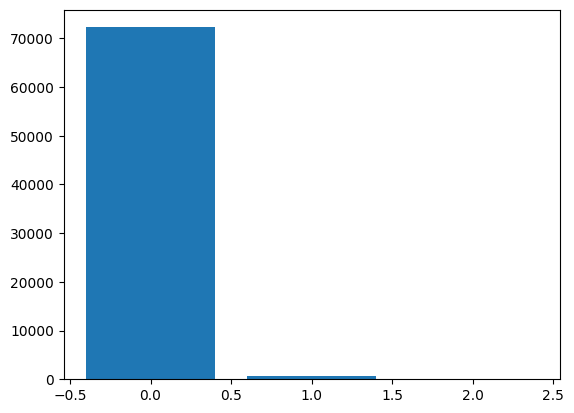

In [48]:
plt.bar(value_counts_NB_SINISTRES.keys(), value_counts_NB_SINISTRES.values)

**BKU**

- Etudier la pertinence dans un cadre de prédiction de garder NB_SINISTRES 

    - en version catégorielle : prédiction uniquement des modalités déjà rencontrées. Quid s

    - en version numérique : prédiction de valeurs potentiellement réelles, mais avec l'avantage de permettre de prédire des valeurs supérieures à 2



### `CHARGE`

**Distribution des valeurs**

In [49]:
base_auto.CHARGE.describe()

count    72878.000000
mean        21.525779
std        351.454691
min      -6258.800000
25%          0.000000
50%          0.000000
75%          0.000000
max      13154.600000
Name: CHARGE, dtype: float64

75% des valeurs de `CHARGE` sont nulles.

**ANOMALIE** : des valeurs sont négatives

In [50]:
anomalies_CHARGE = base_auto.loc[base_auto.CHARGE < 0]
anomalies_CHARGE

,FORMULE,EXPOSITION,V_TYPE_GARAGE,V_MARQUE,V_GROUPE_SRA,V_PUISSANCE,V_USAGE,C_CSP,C_ZONE_RISQUE,C_TYPE_PERMIS,...,C_ANCIENNETE_ASSURANCE,C_ANCIENNETE_PERMIS,C_AGE,V_ANCIENNETE,CHARGE,NB_SINISTRES,ID,CODE_POSTAL,ANNEE_OBS,MOIS_OBS
9242,TOUT_RISQUE,0.084873,VOIE_PUBLIQUE,MODEL2,1.0,1.0,PRIVE_ET_UTILISATION_PRO,ETUDIANT,2,P1,...,0,3.43,16.93,2.39,-37.54,1.0,345,14450.0,2019,3
12430,TOUT_RISQUE,0.084873,BOX_FERME,MODEL4,1.0,1.0,PRIVE_UNIQUEMENT,SALARIE,2,AUCUN,...,12,0.88,39.01,1.38,-910.81,1.0,453,30100.0,2018,7
13399,TOUT_RISQUE,0.076660,PARKING_FERME,MODEL4,1.0,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,2,AUCUN,...,12,0.46,36.35,0.96,-6258.80,2.0,486,64000.0,2018,3
17019,TOUT_RISQUE,0.060233,VOIE_PUBLIQUE,MODEL4,1.0,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,1,AUCUN,...,12,-0.47,54.70,6.00,-1400.00,1.0,621,41130.0,2017,7
20078,TOUT_RISQUE,0.076660,BOX_FERME,MODEL4,1.0,6.0,PRIVE_ET_UTILISATION_PRO,SALARIE,2,AUCUN,...,12,-0.15,57.77,5.69,-20.00,1.0,737,72210.0,2018,2
21568,CONFORT,0.079398,BOX_FERME,MODEL4,1.0,1.0,PRIVE_UNIQUEMENT,RETRAITE,1,AUCUN,...,0,0.73,59.85,5.07,-4000.00,1.0,792,88400.0,2019,2
22332,TOUT_RISQUE,0.082136,PARKING_OUVERT,MODEL4,1.0,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,4,P1,...,0,1.33,16.85,9.58,-20.00,1.0,827,71000.0,2018,4
25608,TOUT_RISQUE,0.084873,VOIE_PUBLIQUE,MODEL4,1.0,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,2,AUCUN,...,12,1.86,59.01,3.40,-234.40,1.0,934,22560.0,2020,7
27964,TOUT_RISQUE,0.082136,VOIE_PUBLIQUE,MODEL6,1.0,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,1,P1,...,12,3.69,23.35,6.31,-0.01,1.0,1022,83210.0,2020,6
31116,TOUT_RISQUE,0.082136,VOIE_PUBLIQUE,MODEL2,1.0,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,2,AUCUN,...,12,2.26,38.27,2.09,-855.00,1.0,1145,51000.0,2021,4


## Variables explicatives

### Inventaire et types

In [51]:
print(f"{len(base_auto.columns)} VARIABLES :")
print("============")
for c in base_auto.columns: print(c)

21 VARIABLES :
FORMULE
EXPOSITION
V_TYPE_GARAGE
V_MARQUE
V_GROUPE_SRA
V_PUISSANCE
V_USAGE
C_CSP
C_ZONE_RISQUE
C_TYPE_PERMIS
C_CRM
C_ANCIENNETE_ASSURANCE
C_ANCIENNETE_PERMIS
C_AGE
V_ANCIENNETE
CHARGE
NB_SINISTRES
ID
CODE_POSTAL
ANNEE_OBS
MOIS_OBS


### Variables numériques

In [52]:
base_auto_numerical_columns = base_auto.select_dtypes(include='number').columns

print(f"{len(base_auto_numerical_columns)} VARIABLES NUMERIQUES :")
print("=======================")
for c in base_auto_numerical_columns: print(c)

12 VARIABLES NUMERIQUES :
EXPOSITION
V_GROUPE_SRA
C_CRM
C_ANCIENNETE_ASSURANCE
C_ANCIENNETE_PERMIS
C_AGE
V_ANCIENNETE
CHARGE
NB_SINISTRES
ID
ANNEE_OBS
MOIS_OBS


In [53]:
base_auto[base_auto_numerical_columns].describe()

,EXPOSITION,V_GROUPE_SRA,C_CRM,C_ANCIENNETE_ASSURANCE,C_ANCIENNETE_PERMIS,C_AGE,V_ANCIENNETE,CHARGE,NB_SINISTRES,ID,ANNEE_OBS,MOIS_OBS
count,72878.000000,72878.000000,72878.000000,72878.0,72878.000000,65460.000000,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000
mean,0.075626,0.999767,97.409698,7.432531,2.387273,46.883134,5.762926,21.525779,0.008741,1451.338730,2019.738838,6.411825
std,0.019123,0.015271,7.209450,5.864715,6.363081,15.666065,4.724290,351.454691,0.096556,933.302155,1.549749,3.470973
min,0.002738,0.000000,72.000000,0.0,-0.750000,14.520000,-1.140000,-6258.800000,0.000000,0.000000,2016.000000,1.000000
25%,0.079398,1.000000,95.000000,0.0,0.040000,36.600000,1.600000,0.000000,0.000000,669.000000,2019.000000,3.000000
50%,0.082136,1.000000,100.000000,12.0,0.750000,48.600000,4.520000,0.000000,0.000000,1346.000000,2020.000000,6.000000
75%,0.084873,1.000000,100.000000,12.0,2.050000,58.612500,9.400000,0.000000,0.000000,2141.000000,2021.000000,9.000000
max,0.084873,1.000000,195.000000,24.0,57.320000,80.070000,19.580000,13154.600000,2.000000,3687.000000,2022.000000,12.000000


**BKU**

- comprendre comment sont indexées les lignes.

    - y-a-t-il un historique des `ID`. **BKU : OUI**

    - comment fonctionne `MOIS_OBS` sachant que min=1 et max=12. **BKU : 1=janvier à 12=décembre**

    - voir si on peut en déduire une durée de contrat (i.e. écart entre min et max)

- Décider si `ANNEE_OBS` doit être catégorisée. Vérifier que les donnnées sont bien entières.

    - **BKU : !!! la version numérique permet de calculer la distance entre 2 dates**

- Clarifier ce qu'est `V_GROUPE_SRA`

- Clarifier ce qu'est `C_ZONE_RISQUE` : vérifier si les données sont entières et si elles peuvent passer catégorielles

- ATTENTION : `C_ANCIENNETE_PERMIS` / `V_ANCIENNETE` ont une valeur minimale négative. Faire l'inventaire des valeurs sous 0.

- ATTENTION : `CHARGE` a une valeur minimale négative. Faire l'inventaire des valeurs sous 0.

### Variables catégorielles

In [54]:
base_auto_categorical_columns = base_auto.select_dtypes(include="object").columns

print(f"{len(base_auto_categorical_columns)} VARIABLES CATEGORIELLES :")
print("=========================")
for c in base_auto_categorical_columns: print(c)

9 VARIABLES CATEGORIELLES :
FORMULE
V_TYPE_GARAGE
V_MARQUE
V_PUISSANCE
V_USAGE
C_CSP
C_ZONE_RISQUE
C_TYPE_PERMIS
CODE_POSTAL


In [55]:
print("DECOMPTE DES MODALITES:")
print("======================")
for c in base_auto_categorical_columns:
    print(base_auto[c].value_counts())
    print(f"{base_auto[c].value_counts().count()} modalités")
    print("")

DECOMPTE DES MODALITES:
FORMULE
TOUT_RISQUE    40062
CONFORT        24368
BASE            8448
Name: count, dtype: int64
3 modalités

V_TYPE_GARAGE
VOIE_PUBLIQUE     32325
BOX_FERME         24596
PARKING_OUVERT    10621
PARKING_FERME      5336
Name: count, dtype: int64
4 modalités

V_MARQUE
MODEL4     34448
MODEL1     15499
MODEL2     11663
MODEL5      3095
MODEL8      2161
MODEL7      1637
MODEL6      1356
MODEL9       982
MODEL3       783
MODEL12      444
MODEL17      313
MODEL13      307
MODEL15       87
MODEL14       42
MODEL10       29
MODEL18       13
MODEL11       10
MODEL16        9
Name: count, dtype: int64
18 modalités

V_PUISSANCE
1.0    66180
6.0     1833
5.0      659
0.0      430
2.0      157
4.0       34
7.0        5
Name: count, dtype: int64
7 modalités

V_USAGE
PRIVE_ET_UTILISATION_PRO    49418
PRIVE_UNIQUEMENT            22563
PRO_UNIQUEMENT                897
Name: count, dtype: int64
3 modalités

C_CSP
SALARIE     46604
RETRAITE    12000
NC           9529
ETUDIANT   

**BKU**:
- Extraire le département de `CODE_POSTAL`


#### `ID`

**Catégorisation des identifiants**

In [56]:
print("INVENTAIRE DES OBSERVATIONS par ID :")
print("==================================")
value_counts_ID = base_auto.ID.value_counts()
value_counts_ID

INVENTAIRE DES OBSERVATIONS par ID :


ID
14      83
52      81
23      81
90      79
96      79
        ..
3142     1
1177     1
1199     1
1211     1
3687     1
Name: count, Length: 3688, dtype: int64

La base répertoirie l'historique de **3688 contrats différents**.

In [57]:
value_counts_ID.values

array([83, 81, 81, ...,  1,  1,  1], dtype=int64)

**Distribution des durées de contrat (ID) dans la base**

<>:11: SyntaxWarning: invalid escape sequence '\o'
<>:11: SyntaxWarning: invalid escape sequence '\o'
C:\Users\bruno\AppData\Local\Temp\ipykernel_22692\1509669184.py:11: SyntaxWarning: invalid escape sequence '\o'
  plt.title('Histogramme des contrats par nombre d\observations')


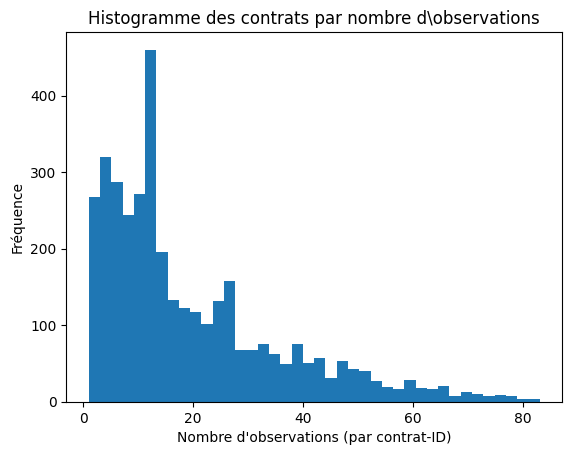

In [58]:

# Extraction des clés et des valeurs du dictionnaire
labels = list(value_counts_ID.keys())
values = list(value_counts_ID.values)

# Création de l'histogramme
plt.hist(value_counts_ID, bins=40)

# Ajout des titres et des labels
plt.xlabel("Nombre d\'observations (par contrat-ID)")
plt.ylabel('Fréquence')
plt.title('Histogramme des contrats par nombre d\observations')

# Affichage de l'histogramme
plt.show()


In [59]:
print(f"{'NOMBRE MOYEN D\'OBSERVATIONS par CONTRAT (ID)': >45} : {(value_counts_ID.values).mean():.2f}")
print(f"{'ECART-TYPE':>45} : {(value_counts_ID.values).std():.2f}")

 NOMBRE MOYEN D'OBSERVATIONS par CONTRAT (ID) : 19.76
                                   ECART-TYPE : 16.25


A un même `ID` est généralement associé plusieurs observations de la base.

L'histogramme précédent donne la fréquence des contrats en fonction du  nombre d'observations qui leur sont associés dans la base.

On note 

- que le nombre moyen d'observations par contrat est de XXX 

- que les contrats avec peu un nombre d'observations inférieur à 40 sont plus nombreux que 

- que les contrats d'une "durée" de 12 ou 24 observations (mois) sont plus nombreux (date anniversaire du contrat = changement fréquent)

**Continuité des contrats**

On vérifie que les observations d'un même contrat (ID) sont continues :

- on calcule le nombre de mois entre le début et la fin du contrat (différence entre le minium et le maximum de `ANNEE_OBS` et `MOIS_OBS` pour l'`ID` en question)

- on collecte le nombre d'observations pour l'`ID` en question

- on vérifie qu'il y a égalité 

par `ID`, Distance entre le début et la fin du contrat 

In [60]:
def distance_mois (observations_for_id):
    
    # conversion des dates (année et mois) en mois
    dates_in_months = observations_for_id["ANNEE_OBS"]*12 + (observations_for_id["MOIS_OBS"]-1)
    
    # dates min et max en mois
    date_min = dates_in_months.min()
    date_max = dates_in_months.max()
    
    # distance entre debut et fin
    distance = date_max - date_min + 1
    
    return distance

# pour chaque ID, calcul de la distance en mois entre la date min et la date max
distance_by_id = base_auto.groupby(["ID"])[["ANNEE_OBS", "MOIS_OBS"]].apply(lambda obs_for_id: distance_mois(obs_for_id))
distance_by_id

ID
0       49
1       33
2        8
3       37
4       55
        ..
3683     1
3684     1
3685     1
3686     1
3687     1
Length: 3688, dtype: int64

Par `ID`, nombre d'observations

In [61]:
nb_obs_by_id = base_auto.groupby(["ID"])[["ANNEE_OBS", "MOIS_OBS"]].apply(lambda obs_for_id: obs_for_id.shape[0])
nb_obs_by_id

ID
0       53
1       32
2        8
3       37
4       59
        ..
3683     1
3684     1
3685     1
3686     1
3687     1
Length: 3688, dtype: int64

Vérification de l'alignement de la durée calculée du contrat et le nombre d'observations

In [62]:
((distance_by_id - nb_obs_by_id)!=0).sum()

2039

NOTE:

- Pour un `ID` donné, on note souvent qu'il y a moins d'observations répertoriés que de mois dans la durée "théorique calculée" du contrat

- Tous les mois d'un contrat n'ont pas été consignés dans la base (quelques unités par contrat)

- BKU : y a-t-il eu interruption du contrat pour reprise ultérieures ?

- Dans la consolidation de la table par `ID`, on consignera la durée "calculée" du contrat i.e. la distance en mois entre le MAX et le MIN des date

**Nombre d'identifiants distincts**

**Nombre de contrats différents traités dans la base**

In [63]:
base_auto.ID.value_counts()

ID
14      83
52      81
23      81
90      79
96      79
        ..
3142     1
1177     1
1199     1
1211     1
3687     1
Name: count, Length: 3688, dtype: int64

#### `FORMULE`

In [64]:
value_counts_FORMULE = base_auto.FORMULE.value_counts()
value_counts_FORMULE

FORMULE
TOUT_RISQUE    40062
CONFORT        24368
BASE            8448
Name: count, dtype: int64

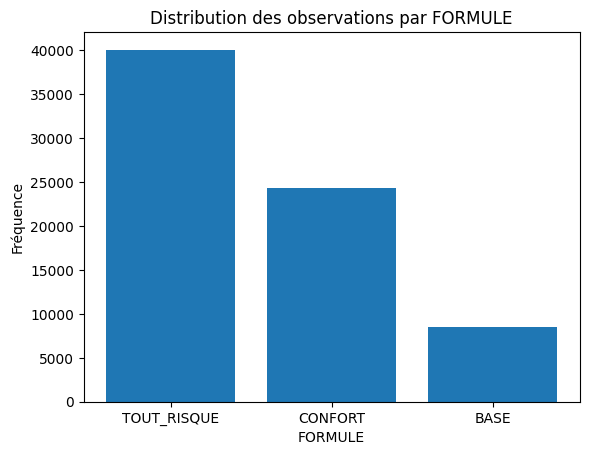

In [65]:
plt.bar(value_counts_FORMULE.keys(), value_counts_FORMULE.values)

plt.xlabel("FORMULE")
plt.ylabel('Fréquence')
plt.title('Distribution des observations par FORMULE')

plt.show()

#### `MARQUE`

**Inventaire des modalités**

In [66]:
v_marque_unique = base_auto.V_MARQUE.unique()

print(f"{'variable V_MARQUE'}")
print(f"{'================='}")
print(f"{'type' : <20} : {base_auto.V_MARQUE.dtype}")
print(f"{'Nombre de modalités' : <20} : {v_marque_unique.shape[0]}")
for m in v_marque_unique:
    print(m)

variable V_MARQUE
type                 : object
Nombre de modalités  : 18
MODEL1
MODEL2
MODEL3
MODEL4
MODEL5
MODEL6
MODEL7
MODEL8
MODEL9
MODEL10
MODEL11
MODEL12
MODEL13
MODEL14
MODEL15
MODEL16
MODEL17
MODEL18


In [67]:
v_marque_value_counts = base_auto.V_MARQUE.value_counts(dropna=False)
v_marque_value_counts

V_MARQUE
MODEL4     34448
MODEL1     15499
MODEL2     11663
MODEL5      3095
MODEL8      2161
MODEL7      1637
MODEL6      1356
MODEL9       982
MODEL3       783
MODEL12      444
MODEL17      313
MODEL13      307
MODEL15       87
MODEL14       42
MODEL10       29
MODEL18       13
MODEL11       10
MODEL16        9
Name: count, dtype: int64

On note une forte disparité des effectifs au travers des modèles/marques.

**BKU**

C'est un décompte des observations.

Les effectifs importants pourraient être liés 

- à un grand nombre de contrats (et donc d'observations) associés au modèle

- à une fidélité des contrats associés au modèle (fidélité => nombreuses observations mensuelles)

Un histogramme du ratio par V_MARQUE du nombre d'observations/nombre de contrats donnerait une visibilité de la fidélité du client.

#### `C_CRM`

Dymanique de `C_CRM`

In [68]:
base_auto.C_CRM.describe()

count    72878.000000
mean        97.409698
std          7.209450
min         72.000000
25%         95.000000
50%        100.000000
75%        100.000000
max        195.000000
Name: C_CRM, dtype: float64

Distribution des valeurs de `C_CRM`

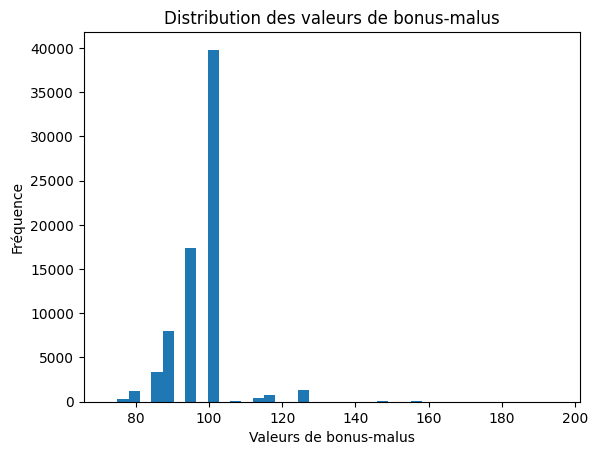

In [69]:
# Création de l'histogramme
plt.hist(base_auto.C_CRM, bins=40)

# Ajout des titres et des labels
plt.title('Distribution des valeurs de bonus-malus')
plt.xlabel("Valeurs de bonus-malus")
plt.ylabel('Fréquence')


# Affichage de l'histogramme
plt.show()

75% des valeurs des valeurs de malus sont supérieurs à 95% (théoriquement compris entre 0.5 et 3.5).

BKU : 

- 3 valeurs sont sous la barre des 0.5 : SITUATION ANORMALE


**ANOMALIE** : valeurs sous la barre des 0.5

In [70]:
( base_auto.C_CRM < 0.5 ).sum()

0

In [71]:
base_auto.loc[base_auto.C_CRM < 0.5]

,FORMULE,EXPOSITION,V_TYPE_GARAGE,V_MARQUE,V_GROUPE_SRA,V_PUISSANCE,V_USAGE,C_CSP,C_ZONE_RISQUE,C_TYPE_PERMIS,...,C_ANCIENNETE_ASSURANCE,C_ANCIENNETE_PERMIS,C_AGE,V_ANCIENNETE,CHARGE,NB_SINISTRES,ID,CODE_POSTAL,ANNEE_OBS,MOIS_OBS


Les 3 valeurs "anormales" de Bonus-Malus sont liées à un même contrat `ID`=3550.

In [72]:
base_auto.loc[base_auto.ID==3550][["ID", "C_CRM", "NB_SINISTRES"]]

,ID,C_CRM,NB_SINISTRES
72427,3550,100.0,0.0
72428,3550,100.0,0.0
72429,3550,100.0,0.0
72430,3550,100.0,0.0
72431,3550,100.0,0.0
72432,3550,100.0,0.0
72433,3550,100.0,0.0
72434,3550,100.0,0.0


L'anomalie doit être dûe à une erreur de saisie.

Dans le cas du dossier `ID`=3550, un historique du Bonus-Malus existe et le nombre de sinistres n'a pas évolué.

On imputera ce cas de figure par une recopie de la valeur historique ; si le nombre de sinistres avait évolué, on aurait appliqué les règles de calcul du Bonus-Malus à la dernière valeur de malus relevé.

#### `C_AGE`

Un grand nombre de contrats est relatif à des conducteur de MOINS de 18 ans.

In [73]:
base_auto.loc[base_auto.C_AGE<=18].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5057 entries, 289 to 72813
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FORMULE                 5057 non-null   object 
 1   EXPOSITION              5057 non-null   float64
 2   V_TYPE_GARAGE           5057 non-null   object 
 3   V_MARQUE                5057 non-null   object 
 4   V_GROUPE_SRA            5057 non-null   float64
 5   V_PUISSANCE             4827 non-null   object 
 6   V_USAGE                 5057 non-null   object 
 7   C_CSP                   5057 non-null   object 
 8   C_ZONE_RISQUE           5057 non-null   object 
 9   C_TYPE_PERMIS           5057 non-null   object 
 10  C_CRM                   5057 non-null   float64
 11  C_ANCIENNETE_ASSURANCE  5057 non-null   Int32  
 12  C_ANCIENNETE_PERMIS     5057 non-null   float64
 13  C_AGE                   5057 non-null   float64
 14  V_ANCIENNETE            5057 non-null   fl

...

# PREPARATION DE LA BASE

## Séparation Y et Features

In [74]:
Y_CHARGE = base_auto.CHARGE
Y_EXPOSITION = base_auto.EXPOSITION
Y_NB_SINISTRES = base_auto.NB_SINISTRES

features = base_auto.drop(columns=["CHARGE", "EXPOSITION", "NB_SINISTRES"])

## Séparation des features selon le type de variables

In [75]:
# features_na = []
# features_numeriques = []
# features_categorielles = []
features_na = pd.DataFrame()
features_numeriques = pd.DataFrame()
features_categorielles = pd.DataFrame()

for colu in features.columns:
    print(colu)
    if True in base_auto[colu].isna().unique() :
        # features_na.append(base_auto[colu])
        features_na = features_na.join(base_auto[colu], how="right")
        # pd.concat(features_na, base_auto[colu], axis=1)
        print("=> Variable avec des NA")
    else :
        if str(base_auto[colu].dtypes) in ["int32","int64","float64"]:
            if len(base_auto[colu].unique())==2 :
                # features_categorielles.append(base_auto[colu])
                features_categorielles = features_categorielles.join(base_auto[colu], how="right")
                # pd.concat(features_categorielles, base_auto[colu], axis=1)
                print("=> Variable binaire")
            else :
                # features_numeriques.append(base_auto[colu])
                features_numeriques = features_numeriques.join(base_auto[colu], how="right")
                # pd.concat(features_numeriques, base_auto[colu], axis=1)
                print("=> Variable numérique")
        else :
            # features_categorielles.append(base_auto[colu])
            features_categorielles = features_categorielles.join(base_auto[colu], how="right")
            # pd.concat(features_categorielles, base_auto[colu], axis=1)
            print("=> Variable catégorielle")

FORMULE
=> Variable catégorielle
V_TYPE_GARAGE
=> Variable catégorielle
V_MARQUE
=> Variable catégorielle
V_GROUPE_SRA
=> Variable binaire
V_PUISSANCE
=> Variable avec des NA
V_USAGE
=> Variable catégorielle
C_CSP
=> Variable catégorielle
C_ZONE_RISQUE
=> Variable avec des NA
C_TYPE_PERMIS
=> Variable catégorielle
C_CRM
=> Variable numérique
C_ANCIENNETE_ASSURANCE
=> Variable catégorielle
C_ANCIENNETE_PERMIS
=> Variable numérique
C_AGE
=> Variable avec des NA
V_ANCIENNETE
=> Variable numérique
ID
=> Variable numérique
CODE_POSTAL
=> Variable avec des NA
ANNEE_OBS
=> Variable numérique
MOIS_OBS
=> Variable numérique


### Vérification de la ventilation (TEMPORAIRE)

**BKU**

Vérifier que join a bien conservé l'indexation des valeurs i.e. les valeurs des base_auto sont bien conservées observation par observation

In [76]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72878 entries, 0 to 72877
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FORMULE                 72878 non-null  object 
 1   V_TYPE_GARAGE           72878 non-null  object 
 2   V_MARQUE                72878 non-null  object 
 3   V_GROUPE_SRA            72878 non-null  float64
 4   V_PUISSANCE             69298 non-null  object 
 5   V_USAGE                 72878 non-null  object 
 6   C_CSP                   72878 non-null  object 
 7   C_ZONE_RISQUE           72862 non-null  object 
 8   C_TYPE_PERMIS           72878 non-null  object 
 9   C_CRM                   72878 non-null  float64
 10  C_ANCIENNETE_ASSURANCE  72878 non-null  Int32  
 11  C_ANCIENNETE_PERMIS     72878 non-null  float64
 12  C_AGE                   65460 non-null  float64
 13  V_ANCIENNETE            72878 non-null  float64
 14  ID                      72878 non-null  int

In [77]:
features_numeriques.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72878 entries, 0 to 72877
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   C_CRM                72878 non-null  float64
 1   C_ANCIENNETE_PERMIS  72878 non-null  float64
 2   V_ANCIENNETE         72878 non-null  float64
 3   ID                   72878 non-null  int64  
 4   ANNEE_OBS            72878 non-null  int64  
 5   MOIS_OBS             72878 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 3.9 MB


In [78]:
features_categorielles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72878 entries, 0 to 72877
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FORMULE                 72878 non-null  object 
 1   V_TYPE_GARAGE           72878 non-null  object 
 2   V_MARQUE                72878 non-null  object 
 3   V_GROUPE_SRA            72878 non-null  float64
 4   V_USAGE                 72878 non-null  object 
 5   C_CSP                   72878 non-null  object 
 6   C_TYPE_PERMIS           72878 non-null  object 
 7   C_ANCIENNETE_ASSURANCE  72878 non-null  Int32  
dtypes: Int32(1), float64(1), object(6)
memory usage: 4.8+ MB


**BKU**

!!! Pourquoi groupe SRA se retrouve dans catégorielle ? bi-modale ?

In [79]:
features_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72878 entries, 0 to 72877
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   V_PUISSANCE    69298 non-null  object 
 1   C_ZONE_RISQUE  72862 non-null  object 
 2   C_AGE          65460 non-null  float64
 3   CODE_POSTAL    71967 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.8+ MB


In [80]:
features_numeriques.shape

(72878, 6)

**BKU**

Pour `C_AGE`, `V_PUISSANCE`, `CODE_POSTAL` : vérifier si l'historique des contrats contient l'information

In [81]:
# vérification de la conservation du nombre d'observations
assert(features.shape[0]==base_auto.shape[0])
assert(features_categorielles.shape[0]==base_auto.shape[0])
assert(features_na.shape[0]==base_auto.shape[0])
assert(features_numeriques.shape[0]==base_auto.shape[0])

# vérification de la conservation du nombre de features
assert(features_categorielles.shape[1]+features_na.shape[1]+features_numeriques.shape[1]==features.shape[1])

In [82]:
if (features.shape[1] != features_na.shape[1]+features_numeriques.shape[1]+features_categorielles.shape[1]):
    # if features.shape[1] != len(features_na)+len(features_numeriques)+len(features_categorielles):
    print("Attention !")
    print("Nombre initial de features = "+str(features.shape[1]))
    print("Après séparation = "+str(len(features_na)+len(features_numeriques)+len(features_categorielles)))
else :
    print("C'est tout bon !")

C'est tout bon !


In [83]:
# La ventilation des features a été modifié ; elle gère directement des dataframes

# features_numeriques = pd.DataFrame(features_numeriques).transpose()
# features_categorielles = pd.DataFrame(features_categorielles).transpose()
# features_na = pd.DataFrame(features_na).transpose()

In [84]:
features_categorielles.head()

,FORMULE,V_TYPE_GARAGE,V_MARQUE,V_GROUPE_SRA,V_USAGE,C_CSP,C_TYPE_PERMIS,C_ANCIENNETE_ASSURANCE
0,BASE,VOIE_PUBLIQUE,MODEL1,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,AUCUN,12
1,BASE,VOIE_PUBLIQUE,MODEL1,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,AUCUN,12
2,BASE,VOIE_PUBLIQUE,MODEL1,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,AUCUN,12
3,BASE,VOIE_PUBLIQUE,MODEL1,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,AUCUN,12
4,BASE,VOIE_PUBLIQUE,MODEL1,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,AUCUN,12


In [85]:
features_numeriques.head()

,C_CRM,C_ANCIENNETE_PERMIS,V_ANCIENNETE,ID,ANNEE_OBS,MOIS_OBS
0,100.0,-0.48,11.37,0,2016,4
1,100.0,-0.41,11.44,0,2016,5
2,100.0,-0.33,11.52,0,2016,6
3,100.0,-0.25,11.60,0,2016,7
4,100.0,-0.16,11.69,0,2016,8


**BKU**

- `C_TYPE_PERMIS` : `AUCUN` => Voiture sans permis ? On devrait retrouver une corrélation entre cette modalité et le modèle `MODEL1`.

- `V_GROUPE_SRA` : voir si on peut clarifier les modalités (0, 1, ...)



In [86]:
features_na.head()

,V_PUISSANCE,C_ZONE_RISQUE,C_AGE,CODE_POSTAL
0,1.0,2,45.53,81700.0
1,1.0,2,45.60,81700.0
2,1.0,2,45.68,81700.0
3,1.0,2,45.77,81700.0
4,1.0,2,45.85,81700.0


## Imputation des données manquantes

### Imputation par historique du contrat

...

### K plus proches voisins

In [87]:
features_na.head()

,V_PUISSANCE,C_ZONE_RISQUE,C_AGE,CODE_POSTAL
0,1.0,2,45.53,81700.0
1,1.0,2,45.60,81700.0
2,1.0,2,45.68,81700.0
3,1.0,2,45.77,81700.0
4,1.0,2,45.85,81700.0


In [88]:
features_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72878 entries, 0 to 72877
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   V_PUISSANCE    69298 non-null  object 
 1   C_ZONE_RISQUE  72862 non-null  object 
 2   C_AGE          65460 non-null  float64
 3   CODE_POSTAL    71967 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.8+ MB


In [89]:
features_na.describe(include="all")


,V_PUISSANCE,C_ZONE_RISQUE,C_AGE,CODE_POSTAL
count,69298.0,72862.0,65460.000000,71967
unique,7.0,4.0,NaN,1884
top,1.0,2.0,NaN,11160.0
freq,66180.0,36327.0,NaN,371
mean,NaN,NaN,46.883134,NaN
std,NaN,NaN,15.666065,NaN
min,NaN,NaN,14.520000,NaN
25%,NaN,NaN,36.600000,NaN
50%,NaN,NaN,48.600000,NaN
75%,NaN,NaN,58.612500,NaN


In [90]:
for c in features_na.columns:
    print(f"Nombre de NA pour {c} : {str(sum(features_na[c].isna()))}")    
    

Nombre de NA pour V_PUISSANCE : 3580
Nombre de NA pour C_ZONE_RISQUE : 16
Nombre de NA pour C_AGE : 7418
Nombre de NA pour CODE_POSTAL : 911


**Variables numériques sans NA : expression en quantiles entre 0 et 1**

In [91]:
int(features_numeriques.shape[0]/200)

364

In [92]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(n_quantiles=int(features_numeriques.shape[0]/200), random_state=0)
features_numeriques_qt = qt.fit_transform(features_numeriques)

features_numeriques_qt = pd.DataFrame(features_numeriques_qt, columns = features_numeriques.columns)
features_numeriques_qt.describe()

,C_CRM,C_ANCIENNETE_PERMIS,V_ANCIENNETE,ID,ANNEE_OBS,MOIS_OBS
count,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000
mean,0.499369,0.500658,0.499299,0.495859,0.505394,0.497859
std,0.261796,0.286917,0.289619,0.288679,0.296011,0.298559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.294766,0.257576,0.247934,0.247934,0.311295,0.214876
50%,0.688705,0.498623,0.497934,0.492591,0.512397,0.472452
75%,0.688705,0.747934,0.748420,0.743189,0.754821,0.709366
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Variables catégorielles sans NA : binarisation**

In [93]:
import sklearn.preprocessing as preproc

preproc_ohe = preproc.OneHotEncoder(drop='first', sparse_output = False).fit(features_categorielles) 
features_categorielles_ohe = preproc_ohe.transform(features_categorielles)

features_categorielles_ohe = pd.DataFrame(features_categorielles_ohe, columns = preproc_ohe.get_feature_names_out(features_categorielles.columns))
features_categorielles_ohe.describe()

,FORMULE_CONFORT,FORMULE_TOUT_RISQUE,V_TYPE_GARAGE_PARKING_FERME,V_TYPE_GARAGE_PARKING_OUVERT,V_TYPE_GARAGE_VOIE_PUBLIQUE,V_MARQUE_MODEL10,V_MARQUE_MODEL11,V_MARQUE_MODEL12,V_MARQUE_MODEL13,V_MARQUE_MODEL14,...,V_USAGE_PRIVE_UNIQUEMENT,V_USAGE_PRO_UNIQUEMENT,C_CSP_NC,C_CSP_RETRAITE,C_CSP_SALARIE,C_TYPE_PERMIS_P1,C_TYPE_PERMIS_P2,C_TYPE_PERMIS_P3,C_ANCIENNETE_ASSURANCE_12.0,C_ANCIENNETE_ASSURANCE_24.0
count,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000,...,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000,72878.000000
mean,0.334367,0.549713,0.073218,0.145737,0.443549,0.000398,0.000137,0.006092,0.004213,0.000576,...,0.309600,0.012308,0.130753,0.164659,0.639480,0.170861,0.042235,0.000069,0.616277,0.001551
std,0.471772,0.497526,0.260496,0.352844,0.496807,0.019944,0.011713,0.077816,0.064768,0.024000,...,0.462332,0.110258,0.337132,0.370875,0.480155,0.376390,0.201126,0.008283,0.486295,0.039347
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Consolidation des features aux valeurs normalisées entre 0 et 1**

In [94]:
X_global = pd.concat([features_numeriques_qt,features_categorielles_ohe], axis = 1)
features_na_2 = features_na.copy()

**Imputation KNN**

cf. https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn

- Cross-validation sur KNN

In [95]:
features_na_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72878 entries, 0 to 72877
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   V_PUISSANCE    69298 non-null  object 
 1   C_ZONE_RISQUE  72862 non-null  object 
 2   C_AGE          65460 non-null  float64
 3   CODE_POSTAL    71967 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.8+ MB


In [96]:
# KNeighborsClassifier ne permet pas des y de type Object 
# Convertir les types Object en category

for c in features_na_2.select_dtypes("object").columns:
    features_na_2[c] = features_na_2[c].astype("category")

features_na_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72878 entries, 0 to 72877
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   V_PUISSANCE    69298 non-null  category
 1   C_ZONE_RISQUE  72862 non-null  category
 2   C_AGE          65460 non-null  float64 
 3   CODE_POSTAL    71967 non-null  category
dtypes: category(3), float64(1)
memory usage: 1.5 MB


In [97]:
# TEMP : 
# KNeighborsClassifier ne permet pas des y de type Object 
# Convertir les types en category

# features_na_2.V_PUISSANCE = features_na_2.V_PUISSANCE.astype("category")
# features_na_2.C_ZONE_RISQUE = features_na_2.C_ZONE_RISQUE.astype("category")
# features_na_2.CODE_POSTAL = features_na_2.CODE_POSTAL.astype("category")



In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

# BKU
from pandas.api.types import is_numeric_dtype

for var_na in features_na_2.columns:
    print(var_na)
    
    features_sans_na = X_global.loc[features[var_na].isna() == False,]
    les_na = X_global.loc[features[var_na].isna() == True,]
    y_sans_na = features_na_2[var_na].loc[features[var_na].isna() == False,]

    # if str(features_na_2[var_na].dtypes) in ["int32","int64","float64"]:
    if is_numeric_dtype(features_na_2[var_na])==True:
        neigh = KNeighborsRegressor(n_neighbors=5)
    else :
        neigh = KNeighborsClassifier(n_neighbors=5)
    
    neigh.fit(X=features_sans_na, y=y_sans_na)
    pred_des_na = neigh.predict(les_na)
    
    #features_na_2[var_na].fillna(pd.Series(pred_des_na))
    features_na_2.loc[features_na_2[var_na].isna(),var_na] = pred_des_na
    
    #print(pred_des_na)

V_PUISSANCE
C_ZONE_RISQUE
C_AGE
CODE_POSTAL


In [99]:
features_na_2.describe(include="all")

,V_PUISSANCE,C_ZONE_RISQUE,C_AGE,CODE_POSTAL
count,72878.0,72878.0,72878.000000,72878
unique,7.0,4.0,NaN,1884
top,1.0,2.0,NaN,11160.0
freq,69618.0,36331.0,NaN,371
mean,NaN,NaN,46.886108,NaN
std,NaN,NaN,15.589630,NaN
min,NaN,NaN,14.520000,NaN
25%,NaN,NaN,36.850000,NaN
50%,NaN,NaN,48.600000,NaN
75%,NaN,NaN,58.501500,NaN


**Intégration des variables imputées**

Vérification que toutes les valeurs sont imputées

In [100]:
features_na_2.isna().sum()

V_PUISSANCE      0
C_ZONE_RISQUE    0
C_AGE            0
CODE_POSTAL      0
dtype: int64

Ventilation des variables entre numériques et catégories

In [101]:
features_na_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72878 entries, 0 to 72877
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   V_PUISSANCE    72878 non-null  category
 1   C_ZONE_RISQUE  72878 non-null  category
 2   C_AGE          72878 non-null  float64 
 3   CODE_POSTAL    72878 non-null  category
dtypes: category(3), float64(1)
memory usage: 1.5 MB


In [102]:
features_numeriques_2 = features_numeriques
features_categorielles_2 = features_categorielles

for c in features_na_2.columns:
    if (features_na_2[c].dtype=="category") : 
        features_categorielles_2[c] = features_na_2[c]
    else:
        features_numeriques_2[c] = features_na_2[c]
        


In [103]:
# A inclure dans une boucle
# features_numeriques_2 = features_numeriques
# features_numeriques_2 = features_numeriques_2.assign(C_AGE = features_na_2.C_AGE)
# features_categorielles_2 = features_categorielles
# features_categorielles_2 = features_categorielles_2.assign(V_PUISSANCE = features_na_2.V_PUISSANCE)
# features_categorielles_2 = features_categorielles_2.assign(C_ZONE_RISQUE = features_na_2.C_ZONE_RISQUE)
# features_categorielles_2 = features_categorielles_2.assign(CODE_POSTAL = features_na_2.CODE_POSTAL)


In [104]:
if features.shape[1] != features_numeriques_2.shape[1]+features_categorielles_2.shape[1]:
    print("Attention !")
    print("Nombre initial de features = "+str(features.shape[1]))
    print("Après séparation = "+str(features_numeriques_2.shape[1]+features_categorielles_2.shape[1]))
else :
    print("C'est tout bon !")

C'est tout bon !


In [105]:
features_categorielles_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72878 entries, 0 to 72877
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   FORMULE                 72878 non-null  object  
 1   V_TYPE_GARAGE           72878 non-null  object  
 2   V_MARQUE                72878 non-null  object  
 3   V_GROUPE_SRA            72878 non-null  float64 
 4   V_USAGE                 72878 non-null  object  
 5   C_CSP                   72878 non-null  object  
 6   C_TYPE_PERMIS           72878 non-null  object  
 7   C_ANCIENNETE_ASSURANCE  72878 non-null  Int32   
 8   V_PUISSANCE             72878 non-null  category
 9   C_ZONE_RISQUE           72878 non-null  category
 10  CODE_POSTAL             72878 non-null  category
dtypes: Int32(1), category(3), float64(1), object(6)
memory usage: 5.2+ MB


In [106]:
features_numeriques_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72878 entries, 0 to 72877
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   C_CRM                72878 non-null  float64
 1   C_ANCIENNETE_PERMIS  72878 non-null  float64
 2   V_ANCIENNETE         72878 non-null  float64
 3   ID                   72878 non-null  int64  
 4   ANNEE_OBS            72878 non-null  int64  
 5   MOIS_OBS             72878 non-null  int64  
 6   C_AGE                72878 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 4.4 MB


## Dépendance entre variables

### V de Cramer

In [107]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [108]:
data_encoded = pd.concat([features_categorielles,features_numeriques_qt],axis=1)
data_encoded.head()

,FORMULE,V_TYPE_GARAGE,V_MARQUE,V_GROUPE_SRA,V_USAGE,C_CSP,C_TYPE_PERMIS,C_ANCIENNETE_ASSURANCE,V_PUISSANCE,C_ZONE_RISQUE,CODE_POSTAL,C_CRM,C_ANCIENNETE_PERMIS,V_ANCIENNETE,ID,ANNEE_OBS,MOIS_OBS
0,BASE,VOIE_PUBLIQUE,MODEL1,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,AUCUN,12,1.0,2,81700.0,0.688705,0.019284,0.839771,0.0,0.0,0.300275
1,BASE,VOIE_PUBLIQUE,MODEL1,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,AUCUN,12,1.0,2,81700.0,0.688705,0.061983,0.842254,0.0,0.0,0.385675
2,BASE,VOIE_PUBLIQUE,MODEL1,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,AUCUN,12,1.0,2,81700.0,0.688705,0.099174,0.845041,0.0,0.0,0.472452
3,BASE,VOIE_PUBLIQUE,MODEL1,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,AUCUN,12,1.0,2,81700.0,0.688705,0.136364,0.848878,0.0,0.0,0.557851
4,BASE,VOIE_PUBLIQUE,MODEL1,1.0,PRIVE_ET_UTILISATION_PRO,SALARIE,AUCUN,12,1.0,2,81700.0,0.688705,0.173554,0.852863,0.0,0.0,0.633609


In [109]:
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

df

,FORMULE,V_TYPE_GARAGE,V_MARQUE,V_GROUPE_SRA,V_USAGE,C_CSP,C_TYPE_PERMIS,C_ANCIENNETE_ASSURANCE,V_PUISSANCE,C_ZONE_RISQUE,CODE_POSTAL,C_CRM,C_ANCIENNETE_PERMIS,V_ANCIENNETE,ID,ANNEE_OBS,MOIS_OBS
FORMULE,1.00,0.00,0.03,0.00,0.01,0.01,0.01,0.00,0.01,0.00,0.63,0.01,0.07,0.19,0.97,0.01,0.00
V_TYPE_GARAGE,0.00,1.00,0.01,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.64,0.00,0.05,0.03,1.00,0.00,0.00
V_MARQUE,0.03,0.01,1.00,0.00,0.00,0.02,0.01,0.00,0.23,0.01,0.69,0.00,0.07,0.03,0.99,0.00,0.00
V_GROUPE_SRA,0.00,0.00,0.00,0.94,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.10,0.02,0.87,0.00,0.00
V_USAGE,0.01,0.01,0.00,0.00,1.00,0.25,0.01,0.00,0.00,0.00,0.64,0.00,0.09,0.03,0.98,0.00,0.00
C_CSP,0.01,0.01,0.02,0.00,0.25,1.00,0.12,0.02,0.01,0.02,0.66,0.01,0.05,0.03,0.99,0.01,0.00
C_TYPE_PERMIS,0.01,0.00,0.01,0.00,0.01,0.12,1.00,0.03,0.00,0.01,0.50,0.01,0.56,0.02,0.99,0.01,0.00
C_ANCIENNETE_ASSURANCE,0.00,0.00,0.00,0.00,0.00,0.02,0.03,1.00,0.00,0.00,0.32,0.02,0.08,0.04,0.54,0.01,0.01
V_PUISSANCE,0.01,0.00,0.23,0.00,0.00,0.01,0.00,0.00,1.00,0.00,0.52,0.00,0.06,0.03,0.97,0.00,0.00
C_ZONE_RISQUE,0.00,0.00,0.01,0.00,0.00,0.02,0.01,0.00,0.00,1.00,0.97,0.01,0.04,0.03,1.00,0.00,0.00


In [110]:
nb_variables = df.shape[0]

In [111]:
for i in range(nb_variables):
  for j in range(i+1,nb_variables) :
    if df.iloc[i,j] > 0.5 :
        print(df.index.to_numpy()[i]+" et "+ df.columns[j] + " sont trop dépendantes, V-CRAMER = " + str(df.iloc[i,j]))

FORMULE et CODE_POSTAL sont trop dépendantes, V-CRAMER = 0.63
FORMULE et ID sont trop dépendantes, V-CRAMER = 0.97
V_TYPE_GARAGE et CODE_POSTAL sont trop dépendantes, V-CRAMER = 0.64
V_TYPE_GARAGE et ID sont trop dépendantes, V-CRAMER = 1.0
V_MARQUE et CODE_POSTAL sont trop dépendantes, V-CRAMER = 0.69
V_MARQUE et ID sont trop dépendantes, V-CRAMER = 0.99
V_GROUPE_SRA et ID sont trop dépendantes, V-CRAMER = 0.87
V_USAGE et CODE_POSTAL sont trop dépendantes, V-CRAMER = 0.64
V_USAGE et ID sont trop dépendantes, V-CRAMER = 0.98
C_CSP et CODE_POSTAL sont trop dépendantes, V-CRAMER = 0.66
C_CSP et ID sont trop dépendantes, V-CRAMER = 0.99
C_TYPE_PERMIS et C_ANCIENNETE_PERMIS sont trop dépendantes, V-CRAMER = 0.56
C_TYPE_PERMIS et ID sont trop dépendantes, V-CRAMER = 0.99
C_ANCIENNETE_ASSURANCE et ID sont trop dépendantes, V-CRAMER = 0.54
V_PUISSANCE et CODE_POSTAL sont trop dépendantes, V-CRAMER = 0.52
V_PUISSANCE et ID sont trop dépendantes, V-CRAMER = 0.97
C_ZONE_RISQUE et CODE_POSTAL son

**BKU**

- Retirer ID de l'analyse ; néanmoins on constate que pour un contrat donné (`ID`), il y a peu de changement

    - de FORMULE

    - de V_TYPE_GARAGE

    - de V_USAGE

    - de C_CSP

    - de C_TYPE_PERMIS

- On note une corrélation acceptable entre C_TYPE_PERMIS et C_ANCIENNETE_PERMIS

- Le V de Cramer ne fait pas apparaître de corrélation fortes qui nécessiterait de supprimer une variable.

### Matrice de corrélation

In [112]:
data_encoded_2 = pd.concat([features_categorielles_ohe,features_numeriques_2],axis=1)
data_encoded_2.head()

,FORMULE_CONFORT,FORMULE_TOUT_RISQUE,V_TYPE_GARAGE_PARKING_FERME,V_TYPE_GARAGE_PARKING_OUVERT,V_TYPE_GARAGE_VOIE_PUBLIQUE,V_MARQUE_MODEL10,V_MARQUE_MODEL11,V_MARQUE_MODEL12,V_MARQUE_MODEL13,V_MARQUE_MODEL14,...,C_TYPE_PERMIS_P3,C_ANCIENNETE_ASSURANCE_12.0,C_ANCIENNETE_ASSURANCE_24.0,C_CRM,C_ANCIENNETE_PERMIS,V_ANCIENNETE,ID,ANNEE_OBS,MOIS_OBS,C_AGE
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,100.0,-0.48,11.37,0,2016,4,45.53
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,100.0,-0.41,11.44,0,2016,5,45.60
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,100.0,-0.33,11.52,0,2016,6,45.68
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,100.0,-0.25,11.60,0,2016,7,45.77
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,100.0,-0.16,11.69,0,2016,8,45.85


In [113]:
df_2 = data_encoded_2.corr()
df_2

,FORMULE_CONFORT,FORMULE_TOUT_RISQUE,V_TYPE_GARAGE_PARKING_FERME,V_TYPE_GARAGE_PARKING_OUVERT,V_TYPE_GARAGE_VOIE_PUBLIQUE,V_MARQUE_MODEL10,V_MARQUE_MODEL11,V_MARQUE_MODEL12,V_MARQUE_MODEL13,V_MARQUE_MODEL14,...,C_TYPE_PERMIS_P3,C_ANCIENNETE_ASSURANCE_12.0,C_ANCIENNETE_ASSURANCE_24.0,C_CRM,C_ANCIENNETE_PERMIS,V_ANCIENNETE,ID,ANNEE_OBS,MOIS_OBS,C_AGE
FORMULE_CONFORT,1.000000,-0.783101,-0.007725,-0.020634,0.010631,0.019401,0.016529,0.050288,0.059435,0.033881,...,0.011687,0.004042,-0.002797,-0.090719,-0.000653,0.311633,-0.082614,-0.066063,0.003776,0.078927
FORMULE_TOUT_RISQUE,-0.783101,1.000000,0.022840,0.048345,-0.022399,-0.013748,-0.012944,-0.043974,-0.041204,-0.026532,...,-0.009152,0.029420,0.006927,0.091142,-0.061237,-0.518635,0.108575,0.097323,-0.005829,-0.092539
V_TYPE_GARAGE_PARKING_FERME,-0.007725,0.022840,1.000000,-0.116094,-0.250945,-0.005608,-0.003293,-0.001021,-0.018281,-0.006750,...,-0.002328,-0.013914,-0.003044,0.011448,0.036957,-0.031041,0.048572,0.035946,-0.002618,-0.050404
V_TYPE_GARAGE_PARKING_OUVERT,-0.020634,0.048345,-0.116094,1.000000,-0.368762,-0.008241,0.015082,-0.028839,-0.019659,-0.009918,...,-0.003421,-0.023389,-0.001451,0.041954,-0.033524,-0.038126,0.063253,0.033997,-0.002935,-0.003588
V_TYPE_GARAGE_VOIE_PUBLIQUE,0.010631,-0.022399,-0.250945,-0.368762,1.000000,-0.009504,-0.001027,-0.023048,0.018265,-0.001875,...,0.009278,0.021859,0.004829,-0.016495,-0.047480,0.056394,-0.025342,-0.003848,0.002934,-0.038360
V_MARQUE_MODEL10,0.019401,-0.013748,-0.005608,-0.008241,-0.009504,1.000000,-0.000234,-0.001562,-0.001298,-0.000479,...,-0.000165,-0.016796,-0.000786,0.002397,-0.006416,0.005478,-0.013005,-0.021943,-0.000583,-0.034343
V_MARQUE_MODEL11,0.016529,-0.012944,-0.003293,0.015082,-0.001027,-0.000234,1.000000,-0.000917,-0.000762,-0.000281,...,-0.000097,-0.000392,-0.000462,0.004209,-0.004618,0.016602,-0.009406,-0.019191,0.009748,-0.012245
V_MARQUE_MODEL12,0.050288,-0.043974,-0.001021,-0.028839,-0.023048,-0.001562,-0.000917,1.000000,-0.005092,-0.001880,...,-0.000649,-0.020533,-0.003085,0.018469,0.033802,-0.009216,0.023279,-0.004443,-0.000196,-0.085737
V_MARQUE_MODEL13,0.059435,-0.041204,-0.018281,-0.019659,0.018265,-0.001298,-0.000762,-0.005092,1.000000,-0.001562,...,-0.000539,0.034767,0.002821,-0.022739,-0.007016,0.010406,-0.026321,-0.017611,0.001317,0.023606
V_MARQUE_MODEL14,0.033881,-0.026532,-0.006750,-0.009918,-0.001875,-0.000479,-0.000281,-0.001880,-0.001562,1.000000,...,-0.000199,-0.016323,-0.000946,0.004266,-0.002531,0.025038,0.010972,0.002202,-0.000872,-0.036830


In [114]:
nb_variables = df_2.shape[0]
for i in range(nb_variables):
  for j in range(i+1,nb_variables) :
    if abs(df_2.iloc[i,j]) > 0.5 :
        print(df_2.index.to_numpy()[i]+" et "+ df_2.columns[j] + " sont trop dépendantes, corr = " + str(df_2.iloc[i,j]))

FORMULE_CONFORT et FORMULE_TOUT_RISQUE sont trop dépendantes, corr = -0.783101034131186
FORMULE_TOUT_RISQUE et V_ANCIENNETE sont trop dépendantes, corr = -0.5186354583523646
V_USAGE_PRIVE_UNIQUEMENT et C_CSP_RETRAITE sont trop dépendantes, corr = 0.5811296598284482
V_USAGE_PRIVE_UNIQUEMENT et C_CSP_SALARIE sont trop dépendantes, corr = -0.6548748846076564
C_CSP_NC et C_CSP_SALARIE sont trop dépendantes, corr = -0.5165380047446436
C_CSP_RETRAITE et C_CSP_SALARIE sont trop dépendantes, corr = -0.591301436241785
C_CSP_RETRAITE et C_AGE sont trop dépendantes, corr = 0.5769751269544223
C_TYPE_PERMIS_P1 et C_AGE sont trop dépendantes, corr = -0.7149275162522527
C_TYPE_PERMIS_P2 et C_ANCIENNETE_PERMIS sont trop dépendantes, corr = 0.8128601169476944
ID et ANNEE_OBS sont trop dépendantes, corr = 0.7010637946357661


On note des corrélations relativement fortes

- entre FORMULE_CONFORT et FORMULE_TOUT_RISQUE (corrélation négative) ; ce sont les 2 formules majoritaires

- C_TYPE_PERMIS_P1 et C_AGE (corrélation négative) 

- C_TYPE_PERMIS_P2 et C_ANCIENNETE_PERMIS (corrélation positive)


In [115]:
base_auto.FORMULE.value_counts()

FORMULE
TOUT_RISQUE    40062
CONFORT        24368
BASE            8448
Name: count, dtype: int64

## Séparation Train / Test et preprocessing

On prend le parti de faire le preprocessing après séparation Train / Test pour éviter les fuites de données.

BKU : ATTENTION, `train_size` vaut 0.2 pour la phase de mise au point des modèles. A positionner à 0.8 pour la modélisation finale.

In [116]:
import sklearn.preprocessing as preproc
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

X_train_numeriques, X_test_numeriques, \
X_train_categorielles, X_test_categorielles, \
y_train_exposition, y_test_exposition, \
y_train_charge, y_test_charge, \
y_train_nb_sinistres, y_test_nb_sinistres = train_test_split(features_numeriques_2, 
                                                             features_categorielles_2, 
                                                             Y_EXPOSITION, Y_CHARGE, Y_NB_SINISTRES, 
                                                             random_state=0, train_size=0.2)


**BKU**

ATTENTION : il y a des "modalités" CODE_POSTAL non rencontrées dans le jeu de test

In [117]:
# !!! A FAIRE QUAND TOUS LES NA SONT ETE IMPUTES (code à déplacer)
# ================================================

preproc_norm = preproc.Normalizer(norm='l2').fit(X_train_numeriques)
X_train_numeriques_norm = preproc_norm.transform(X_train_numeriques)
X_test_numeriques_norm = preproc_norm.transform(X_test_numeriques)
global_columns = features_numeriques_2.columns.to_list()

preproc_ohe = preproc.OneHotEncoder(drop='first',
                                    handle_unknown='ignore', # Dans le cas où de nouvelles modalités sont rencontrées (CODE_POSTAL par ex.)
                                    ).fit(X_train_categorielles)
X_train_categorielles_ohe = preproc_ohe.transform(X_train_categorielles)
X_test_categorielles_ohe = preproc_ohe.transform(X_test_categorielles)

global_columns = global_columns + preproc_ohe.get_feature_names_out(X_train_categorielles.columns).tolist()

X_train_global = hstack((X_train_numeriques_norm,X_train_categorielles_ohe))
X_test_global = hstack((X_test_numeriques_norm,X_test_categorielles_ohe))

c:\Users\bruno\OneDrive\_MASTER_\_MODULE 3_\09. MACHINE LEARNING pour l'ACTUARIAT\PROJET_ACTUARIAT\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# SAUVEGARDE

In [118]:
import pickle

# open a file, where you ant to store the data
file = open(FILENAME_PREPROCESSED, 'wb')

data = [{
        # features imputées brutes (sans preprocessing)
         'X_train_numeriques':X_train_numeriques,
         'X_test_numeriques':X_test_numeriques, 
         'X_train_categorielles':X_train_categorielles, 
         'X_test_categorielles':X_test_categorielles, 

        # features imputées avec preprocessing (Normlizer et ohe)
         'X_train_numeriques_norm':X_train_numeriques_norm, 
         'X_test_numeriques_norm':X_test_numeriques_norm,
         'X_train_categorielles_ohe':X_train_categorielles_ohe, 
         'X_test_categorielles_ohe':X_test_categorielles_ohe,
         
        # features imputées avec preprocessing, concaténées
         'global_columns':global_columns, # noms de colonnes
         'X_train_global':X_train_global, 
         'X_test_global':X_test_global,
        
        # Transformers fittés utilisés pour le preprocessing
         'preproc_norm':preproc_norm,
         'preproc_ohe':preproc_ohe,
         
        # Variables d'intérêt brutes         
         'y_train_charge':y_train_charge, 
         'y_train_exposition': y_train_exposition,
         'y_train_nb_sinistres': y_train_nb_sinistres,
         'y_test_charge':y_test_charge, 
         'y_test_exposition': y_test_exposition,
         'y_test_nb_sinistres': y_test_nb_sinistres,
        }]
# dump information to that file
pickle.dump(data, file)

# close the file
file.close()

# ENVIRONNEMENT D'EXECUTION

Le notebook a été exécuté dans le contexte suivant :

In [119]:
print(f"version python : {sys.version}")

version python : 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]


In [120]:
pip freeze

annotated-types==0.7.0
asttokens==2.4.1
attrs==23.2.0
certifi==2024.6.2
charset-normalizer==3.3.2
cloudpickle==3.0.0
colorama==0.4.6
comm==0.2.2
contourpy==1.2.1
cycler==0.12.1
dacite==1.8.1
debugpy==1.8.1
decorator==5.1.1
executing==2.0.1
fonttools==4.53.0
htmlmin==0.1.12
idna==3.7
ImageHash==4.3.1
imbalanced-learn==0.12.3
ipykernel==6.29.4
ipython==8.25.0
jedi==0.19.1
Jinja2==3.1.4
joblib==1.4.2
jupyter_client==8.6.2
jupyter_core==5.7.2
kiwisolver==1.4.5
llvmlite==0.43.0
MarkupSafe==2.1.5
matplotlib==3.8.4
matplotlib-inline==0.1.7
multimethod==1.11.2
nest-asyncio==1.6.0
networkx==3.3
numba==0.60.0
numpy==1.26.4
packaging==24.0
pandas==2.2.2
parso==0.8.4
patsy==0.5.6
phik==0.12.4
pillow==10.3.0
platformdirs==4.2.2
prompt_toolkit==3.0.45
psutil==5.9.8
pure-eval==0.2.2
pydantic==2.7.4
pydantic_core==2.18.4
Pygments==2.18.0
pyparsing==3.1.2
python-dateutil==2.9.0.post0
pytz==2024.1
PyWavelets==1.6.0
pywin32==306
PyYAML==6.0.1
pyzmq==26.0.3
requests==2.32.3
scikit-learn==1.5.0
scipy==1.13